In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

In [3]:
Gfile = '../data/kepler_dr2_1arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')
gaia = data.to_pandas()
print(gaia.shape)

rot_file = '../data/Table_Periodic.txt'
rot = pd.read_csv(rot_file)
df = pd.merge(rot, gaia, right_on='kepid', left_on='KID')
print(df.shape)

ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              (gaia[u'r_modality_flag'] == 1) & 
              (gaia[u'r_result_flag'] == 1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]
print(ok.shape)

(195830, 101)
(33538, 112)
(30305,)


In [11]:
#  MIST isochrones
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '../iso/mist/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.) & 
                    (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]
mist_ms2 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] > 8.11) & (mist['log10_isochrone_age_yr'] < 8.2))[0][::-1]


# but now I like MIST better for this I think
Mg_iso_mist = np.interp(df[u'bp_rp'].values[ok], mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
                        mist['Gaia_G_DR2Rev'].values[mist_ms1])

delta_mag_mist = Mg_iso_mist - (df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5)

dok = np.isfinite(delta_mag_mist)
dmag_lims = [[-0.1, 0.4], [0.5, 1.]]

# main sequence stars
msok = np.where((delta_mag_mist >= dmag_lims[0][0]) & 
                (delta_mag_mist <= dmag_lims[0][1]))[0]
print(msok.shape)

(16248,)


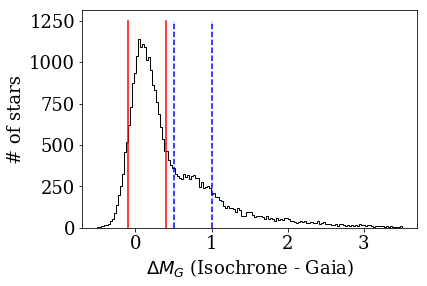

In [12]:
bsok = np.where((delta_mag_mist >= dmag_lims[1][0]) & 
                (delta_mag_mist <= dmag_lims[1][1]))[0]


_ = plt.hist(delta_mag_mist[dok], range=(-0.5,3.5), bins=150, histtype='step', lw=1, color='k')
plt.ylabel('# of stars')
plt.xlabel(r'$\Delta M_G$ (Isochrone - Gaia)')

plt.plot([dmag_lims[0][0],dmag_lims[0][0]], [0,1250], c='r')
plt.plot([dmag_lims[0][1],dmag_lims[0][1]], [0,1250], c='r')

plt.plot([dmag_lims[1][0],dmag_lims[1][0]], [0,1250], c='b', linestyle='--')
plt.plot([dmag_lims[1][1],dmag_lims[1][1]], [0,1250], c='b', linestyle='--')

## Singles vs Binaries

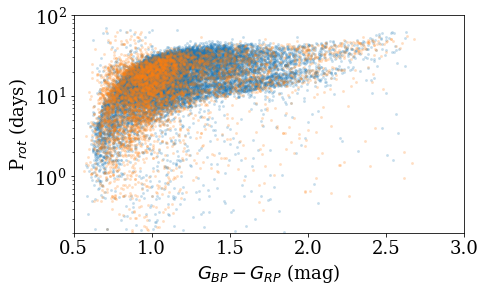

In [13]:
plt.figure(figsize=(7,4))
plt.scatter(df[u'bp_rp'].values[ok][msok], df[u'Prot'].values[ok][msok], 
            s=8, alpha=0.25, lw=0)
plt.scatter(df[u'bp_rp'].values[ok][bsok], df[u'Prot'].values[ok][bsok], 
            s=8, alpha=0.25, lw=0)

plt.yscale('log')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('P$_{rot}$ (days)');
plt.xlim(0.5,3)
plt.ylim(0.2,100)
plt.show()

Text(0.5,1,'1 < $G_{BP} - G_{RP}$ < 1.2')

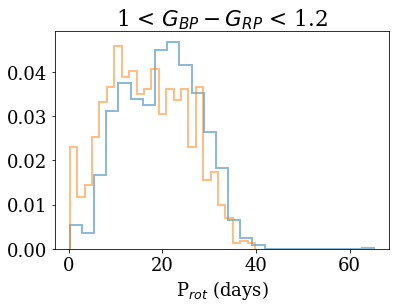

In [14]:
ms1 = np.where((df[u'bp_rp'].values[ok][msok] >= 1) & (df[u'bp_rp'].values[ok][msok] <= 1.2))
bs1 = np.where((df[u'bp_rp'].values[ok][bsok] >= 1) & (df[u'bp_rp'].values[ok][bsok] <= 1.2))

_ = plt.hist((df[u'Prot'].values[ok][msok][ms1]), histtype='step', bins=25,
             normed=True, lw=2, alpha=0.5)
_ = plt.hist((df[u'Prot'].values[ok][bsok][bs1]), histtype='step', bins=25,
             normed=True, lw=2, alpha=0.5)

plt.xlabel('P$_{rot}$ (days)');
plt.title('1 < $G_{BP} - G_{RP}$ < 1.2')



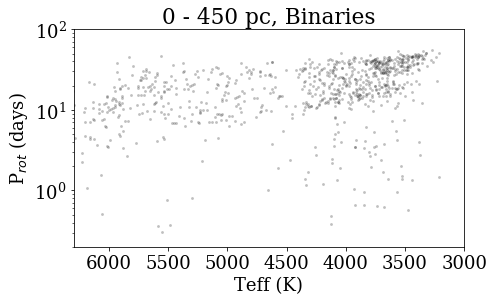

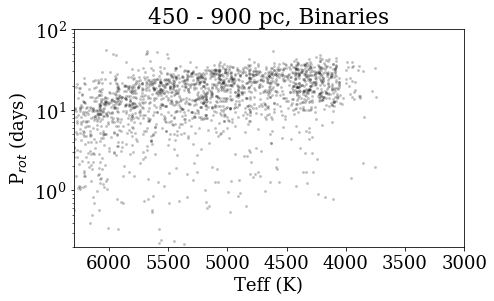

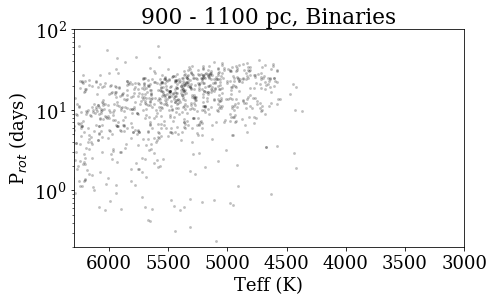

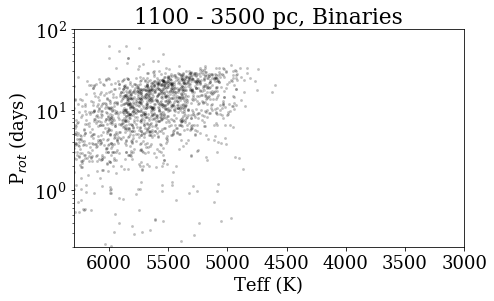

In [15]:
bdist = df[u'r_est'].values[ok][bsok]
bbins = np.array([0, 450, 900, 1100, 3500])


for k in range(len(bbins)-1):
    dd = np.where((bdist >= bbins[k]) & (bdist < bbins[k+1]))
    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'Teff'].values[ok][bsok][dd], df[u'Prot'].values[ok][bsok][dd], 
                s=8, alpha=0.25, c='k', lw=0)

    plt.yscale('log')
    plt.xlabel('Teff (K)')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(6300,3000)
    plt.ylim(0.2,100)
    plt.title(str(bbins[k]) + ' - ' + str(bbins[k+1]) + ' pc, Binaries')
    plt.show()